In [ ]:
"""
NOTE: This code was originally run with a private dataset from Company X.
Due to data privacy and confidentiality agreements, the actual data is not shared.
Please replace 'your_dataset' with your own data to run the script.
"""

# Approach 2: Siamese Architecture With Contrastive Loss

In [1]:
#importing required libraries

import os
import glob2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import time
import sys
import torchvision
import torch.optim as optim
from tqdm import tqdm
from statistics import mean
import itertools
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Setting seed to ensure that the random numbers generated are deterministic.
random_seed = 2
torch.manual_seed(random_seed) 

In [3]:
# Main folder where the class wise images are stored in the respective folders
"""
Original dataset contains the typical semiconductor wafer defects. The defects are similar to the the types of defects 
found in the open source kaggle dataset : https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map
"""

print(os.listdir("./your_dataset"))

['Donut', 'Scratch', 'Random', 'Edge-loc', 'Edge-ring', 'Center', 'Near-Full', 'None', 'Blacklist', 'Loc']


In [4]:
"""
Storing the path of each class in a variable with the class name.

"""

donut_path = "./Donut"
scratch_path = "./Scratch"
random_path = "./Random"
edgeloc_path = "./Edge-loc"
edgering_path = "./Edge-ring"
center_path = "./Center"
nearfull_path = "./Near-Full"
loc_path = "./Loc"
none_path = "./None"

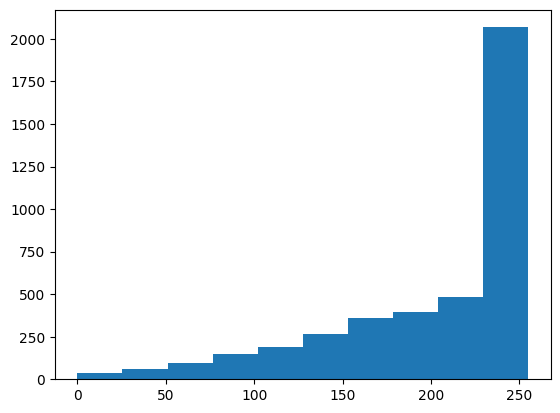

In [72]:
# Histogram of unnormalized pixels ranging from 0 - 255.

unnorm_img = cv2.imread(os.path.join(random_path,"9.png"))
unnorm_img = cv2.cvtColor(unnorm_img , cv2.COLOR_RGB2GRAY)
unnorm_img = np.array(unnorm_img)

pixels =[]
for i in range(64):
    for j in range(64):
        pixels.append(unnorm_img[i][j])


plt.hist(pixels)
plt.show()

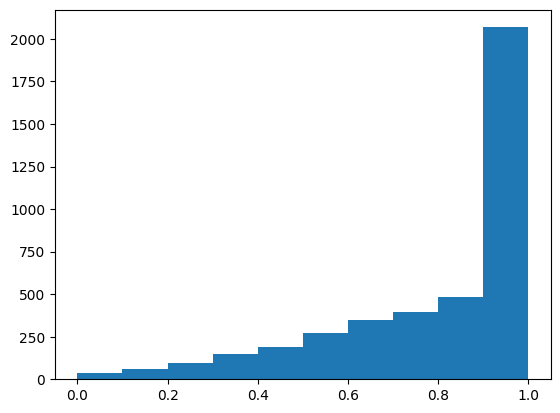

In [5]:
# Histogram of normalized pixels ranging from 0 - 1.

unnorm_img = cv2.imread(os.path.join(random_path,"9.png"))
unnorm_img = cv2.cvtColor(unnorm_img , cv2.COLOR_RGB2GRAY)

img = np.array(unnorm_img)
min_val = np.min(unnorm_img)
max_val = np.max(unnorm_img)

if max_val != min_val:
    img = (unnorm_img - min_val) / (max_val - min_val)
else:
    img = np.ones_like(unnorm_img)

pixels =[]
for i in range(64):
    for j in range(64):
        pixels.append(img[i][j])


plt.hist(pixels)
plt.show()

In [6]:
def read_imgs(class_name, path):
    labeled_imgs = []
    for filename in os.listdir(path):
        
        # Reading images from each folders
        img = cv2.imread(os.path.join(path,filename))
        
        #converting images from RGB to grayscle images with single channel.
        img = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
    
        #Min - max normalizing images
        min_val = np.min(img)
        max_val = np.max(img)

        if max_val != min_val:
            img = (img - min_val) / (max_val - min_val)
        else:
            img = np.ones_like(img)
        
        #Label encoding = {donut:0, scratch:1, Random:2, Edge-loc:3, Edge-ring:4, center:5, Near-Full:6, Loc:7, None:8, Blacklist:9}
        if class_name == "donut":
            labeled_imgs.append((img, 0))
        elif class_name == "scratch":
            labeled_imgs.append((img, 1)) 
        elif class_name == "random":
            labeled_imgs.append((img, 2))
        elif class_name == "edgeloc":
            labeled_imgs.append((img, 3))
        elif class_name == "edgering":
            labeled_imgs.append((img, 4))
        elif class_name == "center":
            labeled_imgs.append((img, 5))
        elif class_name == "nearfull":
            labeled_imgs.append((img, 6))
        elif class_name == "loc":
            labeled_imgs.append((img, 7))
        elif class_name == "none":
            labeled_imgs.append((img, 8))
        elif class_name == "blacklist":
            labeled_imgs.append((img, 9))
        
    return labeled_imgs


In [7]:
donut = read_imgs("donut", donut_path)
scratch = read_imgs("scratch", scratch_path)
random_ = read_imgs("random", random_path)
edgeloc = read_imgs("edgeloc", edgeloc_path)
edgering = read_imgs("edgering", edgering_path)
center = read_imgs("center", center_path)
nearfull = read_imgs("nearfull", nearfull_path)
loc = read_imgs("loc", loc_path)
none = read_imgs("none", none_path)
#blacklist_imgs = read_imgs("blacklist", blacklist_path)

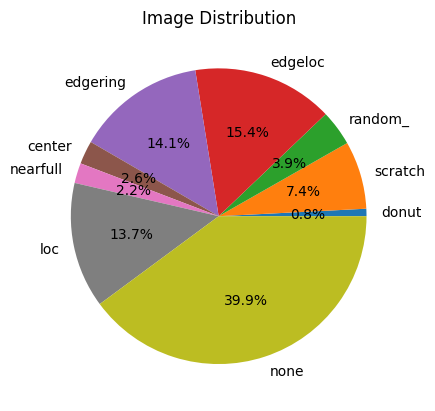

In [8]:
#Class distribution representation with Pie chart.
image_dict = {
    'donut': len(donut),
    'scratch': len(scratch),
    'random_': len(random_),
    'edgeloc': len(edgeloc),
    'edgering': len(edgering),
    'center': len(center),
    'nearfull':len(nearfull),
    'loc': len(loc),
    'none': len(none)
}

classes = list(image_dict.keys())
image_counts = list(image_dict.values())

# Create the pie chart
plt.pie(image_counts, labels=classes, autopct='%1.1f%%')

plt.title('Image Distribution')

plt.show()

In [9]:
# Function to Split 10% data of each class as a test dataset.

def split_data(images, test_size= 0.1):
    # Random seed for reproducibility
    random_seed = 42
    train_imgs, test_imgs = train_test_split(images, test_size=test_size, random_state=random_seed)
    return train_imgs, test_imgs

donut_train, donut_test = split_data(donut)
scratch_train, scratch_test = split_data(scratch)
random_train, random_test = split_data(random_)
edgeloc_train, edgeloc_test = split_data(edgeloc)
edgering_train, edgering_test = split_data(edgering)
center_train, center_test = split_data(center)
nearfull_train, nearfull_test = split_data(nearfull)
loc_train, loc_test = split_data(loc)
none_train, none_test = split_data(none)



In [10]:
print(len(donut_train) ,len(donut_test))
print(len(scratch_train), len(scratch_test))
print(len(random_train), len(random_test))
print(len(edgeloc_train), len(edgeloc_test))
print(len(edgering_train), len(edgering_test))
print(len(center_train), len(center_test))
print(len(nearfull_train), len(nearfull_test))
print(len(loc_train), len(loc_test))
print(len(none_train), len(none_test))

74 9
686 77
359 40
1423 159
1303 145
235 27
203 23
1269 142
3684 410


In [11]:
#Function to create image similar and dissimilar image pairs

def make_pair(data_req, pairing_size, _1, _2, _3, _4, _5, _6, _7, _8):
    positive_pair = []

    for i in range(len(data_req)):
        choice = np.random.choice(len(data_req), size= pairing_size, replace=False)
        for j in range(len(choice)):
            img_1 = data_req[i][0]
            img_2 = data_req[choice[j]][0]
            
            label1 = data_req[i][1]
            label2 = data_req[choice[j]][1]
            
            positive_pair.append((img_1, img_2, label1, label2, 1))

    print("length of positive pair: ", len(positive_pair))    

    #------------------non cat class----------------------
    non_data = list(itertools.chain(_1, _2, _3 ,_4, _5, _6, _7, _8))

    negative_pair =[]
     
    for i in range(len(data_req)):
        choice = np.random.choice(len(non_data), size= pairing_size, replace=False)
      
        for j in range(len(choice)):
            img_1 = data_req[i][0]
            img_2 = non_data[choice[j]][0]
            
            label1 = data_req[i][1]
            label2 = non_data[choice[j]][1]
            
            negative_pair.append((img_1, img_2,  label1, label2, 0))

    print("length of negative pair", len(negative_pair))


    final_data = list(itertools.chain(positive_pair, negative_pair))
   
    random.shuffle(final_data)
    print("=========length of train per class data========: ", len(final_data))
    
    return final_data

In [12]:
#creating image pairs

print("For donut class")
donut_pairs = make_pair(donut_train, 74, scratch, random_, edgeloc, edgering, center,nearfull, loc, none)
print("For scratch class")
scratch_pairs = make_pair(scratch_train, 8, donut, random_, edgeloc, edgering, center,nearfull, loc, none)
print("For random class")
random_pairs = make_pair(random_train, 15, scratch, donut, edgeloc, edgering, center,nearfull, loc, none)
print("For edgeloc class")
edgeloc_pairs = make_pair(edgeloc_train, 4, scratch, random_, donut, edgering, center,nearfull, loc, none)
print("For edgering class")
edgering_pairs = make_pair(edgering_train, 4, scratch, random_, edgeloc, donut, center,nearfull, loc, none)
print("For center class")
center_pairs = make_pair(center_train, 24, scratch, random_, edgeloc, edgering, donut,nearfull, loc, none)
print("For nearfull class")
nearfull_pairs = make_pair(nearfull_train, 28, scratch, random_, edgeloc, edgering, center,donut, loc, none)
print("For loc class")
loc_pairs = make_pair(loc_train, 4, scratch, random_, edgeloc, edgering, center,nearfull, donut, none)
print("For none class")
none_pairs = make_pair(none_train, 2, scratch, random_, edgeloc, edgering, center,nearfull, loc, donut)

For donut class
length of positive pair:  5476
length of negative pair 5476
=========length of train per class data========:  10952
For scratch class
length of positive pair:  5488
length of negative pair 5488
=========length of train per class data========:  10976
For random class
length of positive pair:  5385
length of negative pair 5385
=========length of train per class data========:  10770
For edgeloc class
length of positive pair:  5692
length of negative pair 5692
=========length of train per class data========:  11384
For edgering class
length of positive pair:  5212
length of negative pair 5212
=========length of train per class data========:  10424
For center class
length of positive pair:  5640
length of negative pair 5640
=========length of train per class data========:  11280
For nearfull class
length of positive pair:  5684
length of negative pair 5684
=========length of train per class data========:  11368
For loc class
length of positive pair:  5076
length of negative 

In [15]:
#Combining and shuffling the image pairs
combined_data = donut_pairs + scratch_pairs + random_pairs + edgeloc_pairs + edgering_pairs + \
                  center_pairs + nearfull_pairs + loc_pairs + none_pairs
                                 
print(len(combined_data))
random.shuffle(combined_data)

102042


In [16]:
#splitting data into training, validation 

train_, val_ = train_test_split(combined_data, test_size=0.1, random_state=42)

In [21]:
#Setting device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [34]:
#Creating a custom dataset for pytorch framework to take care of image pairs

class SiameseNetworkDataset(Dataset):
    def __init__(self,image_pairs,transform=None):
        self.image_pairs = image_pairs    
        self.transform = transform
        self.pil_img = transforms.ToPILImage()
        
    def __getitem__(self,index):
        img1 =  self.image_pairs[index][0]
        img2 =  self.image_pairs[index][1]
        
        label1 = self.image_pairs[index][2]
        label2 = self.image_pairs[index][3]
        
        sim_label = self.image_pairs[index][4]
       
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
            label1 = torch.from_numpy(np.array([label1], dtype=np.float32))
            label2 = torch.from_numpy(np.array([label2], dtype=np.float32))
            
            sim_label = torch.from_numpy(np.array([sim_label], dtype=np.float32))
        
        return (img1, img2, label1, label2, sim_label)
    
    def __len__(self):
        return len(self.image_pairs)

In [35]:
# Adding data augumentation to images

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()   
])

In [36]:
random_seed = 2
torch.manual_seed(random_seed) 

In [37]:
train_data = SiameseNetworkDataset(train_ , transform=transformation)
val_data = SiameseNetworkDataset(val_ , transform=transformation)

In [38]:
#Setting data loaders

train_loader = DataLoader(train_data, batch_size = 100, shuffle=True, num_workers= 6)
val_loader = DataLoader(val_data, batch_size= 100, shuffle=True, num_workers= 6)

In [39]:
print(len(train_loader))
print(len(val_loader))

919
103


In [40]:
#class defining contrastive loss function

class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin= None):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):

        distance = F.pairwise_distance(output1, output2, keepdim = True)

        pos = (label) * torch.pow(distance, 2)
        neg = (1-label) * torch.pow(torch.clamp(self.margin - (distance + 1e-10), min=0.0), 2)   #small value added to solve NAN gradient problem.
        
        loss_contrastive = torch.mean( pos + neg )
        return loss_contrastive

In [41]:
#Siamese Netowrk Architecture

class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 30, kernel_size=10),
            nn.Tanh(),
            nn.BatchNorm2d(30),
            nn.Dropout2d(p=0.1),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(30, 20, kernel_size=5),
            nn.Tanh(),
            nn.BatchNorm2d(20),
            nn.Dropout2d(p=0.1),

            nn.ReflectionPad2d(1),
            nn.Conv2d(20, 10, kernel_size=3),
            nn.Tanh(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(p=0.1)
        )

        self.fc = nn.Sequential(
            nn.Linear(10*55*55, 800),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            nn.Linear(800, 500),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            nn.Linear(500, 100))

        
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        out = self.fc(out)
        return out

class SiameseNetwork(nn.Module):
    def __init__(self, base_network):
        super(SiameseNetwork, self).__init__()
        self.base_network = base_network
        
    def forward(self, x1, x2):
        output1 = self.base_network(x1)
        output2 = self.base_network(x2)
        return output1, output2

In [42]:
# Initialize the base network and the siamese network
base_network = BaseNetwork()
network = SiameseNetwork(base_network).to(device)

optimizer = optim.Adam(network.parameters(), lr = 0.0001 , weight_decay=0.00001)

scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size= 50 , gamma=0.1)
criterion = ContrastiveLoss(margin= 3.0)
epochs = 100

In [43]:
# Training loop function.

def train(net, num_epochs, training_data, validation_data, trainloader, valloader, name = None):    
    epoch_loss_train =[]
    epoch_loss_val =[]
    tolerance = 0
    for epoch in range(num_epochs):
        running_train =[]
        running_val =[]
        running_loss_train = 0
        running_loss_val = 0
        net.train()
        print("Mode: training   |   epoch: {}".format(epoch+1))
        for batch_idx, data in enumerate(tqdm(trainloader)):
        
            (img1,img2, _, _, label) = data
            
            img1 = img1.to(device)
            img2 = img2.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            output1, output2 = net(img1, img2)
            loss = criterion(output1, output2, label)
            
            running_loss_train += loss.item()
            loss.backward()
            optimizer.step()
            
        print(scheduler.get_last_lr())
        train_loss_per_epoch = (running_loss_train)/len(train_data)
        epoch_loss_train.append(train_loss_per_epoch)
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch {} loss :{}".format(epoch+1, train_loss_per_epoch))
        
        net.eval()
        print("Mode: validation   |   epoch: {}".format(epoch+1))
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(valloader)):
                (img1,img2, _, _, label) = data
                img1 = img1.to(device)
                img2 = img2.to(device)
                label = label.to(device)
                
                output1, output2 = net(img1, img2)
                loss = criterion(output1, output2, label)
                running_loss_val += loss.item()
                
        val_loss_per_epoch = (running_loss_val)/(len(val_data))
        epoch_loss_val.append(val_loss_per_epoch)
        print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch {} loss :{}".format(epoch+1, val_loss_per_epoch))          
        
        if (val_loss_per_epoch >= train_loss_per_epoch):
            tolerance += 1
        else:
            tolerance = 0
            
        if tolerance >= 2:
            #torch.save(net.state_dict(), os.path.join("./", str(name) + ".pt"))   
            print("Trained model is early stopped and saved at {} epoch".format(epoch+1))
            break
        
    return epoch_loss_train, epoch_loss_val, epoch+1

In [104]:
train_loss, val_loss, epochs = train(network, epochs, train_data, val_data, train_loader, val_loader, name = "Elmos_contra_donut" )

Mode: training   |   epoch: 1


100%|██████████| 919/919 [00:53<00:00, 17.28it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 1 loss :0.017927568598019025
Mode: validation   |   epoch: 1


100%|██████████| 103/103 [00:02<00:00, 46.79it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 1 loss :0.01316848182608134
Mode: training   |   epoch: 2


100%|██████████| 919/919 [00:51<00:00, 17.79it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 2 loss :0.013381580366563334
Mode: validation   |   epoch: 2


100%|██████████| 103/103 [00:02<00:00, 47.21it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 2 loss :0.011244149630937665
Mode: training   |   epoch: 3


100%|██████████| 919/919 [00:51<00:00, 17.88it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 3 loss :0.011586855907183275
Mode: validation   |   epoch: 3


100%|██████████| 103/103 [00:02<00:00, 47.82it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 3 loss :0.010537543529275
Mode: training   |   epoch: 4


100%|██████████| 919/919 [00:51<00:00, 17.89it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 4 loss :0.010437766670893855
Mode: validation   |   epoch: 4


100%|██████████| 103/103 [00:02<00:00, 46.48it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 4 loss :0.008783541848296222
Mode: training   |   epoch: 5


100%|██████████| 919/919 [00:51<00:00, 17.84it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 5 loss :0.009395257262728133
Mode: validation   |   epoch: 5


100%|██████████| 103/103 [00:02<00:00, 45.39it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 5 loss :0.008136566765953196
Mode: training   |   epoch: 6


100%|██████████| 919/919 [00:51<00:00, 17.72it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 6 loss :0.008489304446516738
Mode: validation   |   epoch: 6


100%|██████████| 103/103 [00:02<00:00, 44.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 6 loss :0.007322809688604561
Mode: training   |   epoch: 7


100%|██████████| 919/919 [00:51<00:00, 17.83it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 7 loss :0.007567721674032807
Mode: validation   |   epoch: 7


100%|██████████| 103/103 [00:02<00:00, 47.45it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 7 loss :0.006285668050232382
Mode: training   |   epoch: 8


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 8 loss :0.006693369871100356
Mode: validation   |   epoch: 8


100%|██████████| 103/103 [00:02<00:00, 47.22it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 8 loss :0.005318811385436481
Mode: training   |   epoch: 9


100%|██████████| 919/919 [00:51<00:00, 17.86it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 9 loss :0.0058513049054558855
Mode: validation   |   epoch: 9


100%|██████████| 103/103 [00:02<00:00, 46.35it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 9 loss :0.005989624315298754
Mode: training   |   epoch: 10


100%|██████████| 919/919 [00:51<00:00, 17.84it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 10 loss :0.004955604558690055
Mode: validation   |   epoch: 10


100%|██████████| 103/103 [00:02<00:00, 47.62it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 10 loss :0.0038146216646822453
Mode: training   |   epoch: 11


100%|██████████| 919/919 [00:50<00:00, 18.04it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 11 loss :0.004179902370606872
Mode: validation   |   epoch: 11


100%|██████████| 103/103 [00:02<00:00, 47.77it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 11 loss :0.0033133297881210977
Mode: training   |   epoch: 12


100%|██████████| 919/919 [00:51<00:00, 17.88it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 12 loss :0.0035191009445148477
Mode: validation   |   epoch: 12


100%|██████████| 103/103 [00:02<00:00, 46.98it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 12 loss :0.002517889239056431
Mode: training   |   epoch: 13


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 13 loss :0.0030501459113483533
Mode: validation   |   epoch: 13


100%|██████████| 103/103 [00:02<00:00, 46.88it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 13 loss :0.002143132947622591
Mode: training   |   epoch: 14


100%|██████████| 919/919 [00:51<00:00, 17.83it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 14 loss :0.002735106165307165
Mode: validation   |   epoch: 14


100%|██████████| 103/103 [00:02<00:00, 44.80it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 14 loss :0.0022530391487433944
Mode: training   |   epoch: 15


100%|██████████| 919/919 [00:51<00:00, 17.88it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 15 loss :0.0024772595001229924
Mode: validation   |   epoch: 15


100%|██████████| 103/103 [00:02<00:00, 47.93it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 15 loss :0.0016364579757475665
Mode: training   |   epoch: 16


100%|██████████| 919/919 [00:51<00:00, 17.84it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 16 loss :0.002338417768929467
Mode: validation   |   epoch: 16


100%|██████████| 103/103 [00:02<00:00, 47.38it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 16 loss :0.0016338445362121612
Mode: training   |   epoch: 17


100%|██████████| 919/919 [00:51<00:00, 17.75it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 17 loss :0.0021776466161366045
Mode: validation   |   epoch: 17


100%|██████████| 103/103 [00:02<00:00, 48.29it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 17 loss :0.0015593313297648339
Mode: training   |   epoch: 18


100%|██████████| 919/919 [00:51<00:00, 17.98it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 18 loss :0.002058562678627051
Mode: validation   |   epoch: 18


100%|██████████| 103/103 [00:02<00:00, 47.61it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 18 loss :0.0015711989452709234
Mode: training   |   epoch: 19


100%|██████████| 919/919 [00:51<00:00, 17.83it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 19 loss :0.0019782417353094535
Mode: validation   |   epoch: 19


100%|██████████| 103/103 [00:02<00:00, 47.48it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 19 loss :0.0014866515999547645
Mode: training   |   epoch: 20


100%|██████████| 919/919 [00:51<00:00, 17.88it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 20 loss :0.0019290972510490954
Mode: validation   |   epoch: 20


100%|██████████| 103/103 [00:02<00:00, 46.75it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 20 loss :0.0025389421576089218
Mode: training   |   epoch: 21


100%|██████████| 919/919 [00:51<00:00, 17.86it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 21 loss :0.0018606503750276944
Mode: validation   |   epoch: 21


100%|██████████| 103/103 [00:02<00:00, 47.35it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 21 loss :0.0014714307657779286
Mode: training   |   epoch: 22


100%|██████████| 919/919 [00:51<00:00, 17.91it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 22 loss :0.0018254358360410452
Mode: validation   |   epoch: 22


100%|██████████| 103/103 [00:02<00:00, 48.00it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 22 loss :0.0014078392364296447
Mode: training   |   epoch: 23


100%|██████████| 919/919 [00:51<00:00, 17.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 23 loss :0.0017939778459284085
Mode: validation   |   epoch: 23


100%|██████████| 103/103 [00:02<00:00, 47.31it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 23 loss :0.0014518048254693623
Mode: training   |   epoch: 24


100%|██████████| 919/919 [00:51<00:00, 17.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 24 loss :0.0017414947714869675
Mode: validation   |   epoch: 24


100%|██████████| 103/103 [00:02<00:00, 46.85it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 24 loss :0.0013161728796510356
Mode: training   |   epoch: 25


100%|██████████| 919/919 [00:51<00:00, 17.78it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 25 loss :0.001682351193297053
Mode: validation   |   epoch: 25


100%|██████████| 103/103 [00:02<00:00, 48.18it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 25 loss :0.0012386365215504421
Mode: training   |   epoch: 26


100%|██████████| 919/919 [00:51<00:00, 17.92it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 26 loss :0.001628819924500875
Mode: validation   |   epoch: 26


100%|██████████| 103/103 [00:02<00:00, 47.70it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 26 loss :0.001174429839633
Mode: training   |   epoch: 27


100%|██████████| 919/919 [00:51<00:00, 18.01it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 27 loss :0.001544444820081406
Mode: validation   |   epoch: 27


100%|██████████| 103/103 [00:02<00:00, 47.55it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 27 loss :0.001101582610476826
Mode: training   |   epoch: 28


100%|██████████| 919/919 [00:51<00:00, 17.83it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 28 loss :0.0014799463486092387
Mode: validation   |   epoch: 28


100%|██████████| 103/103 [00:02<00:00, 48.34it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 28 loss :0.0010044512075647193
Mode: training   |   epoch: 29


100%|██████████| 919/919 [00:51<00:00, 17.88it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 29 loss :0.0013668255287163432
Mode: validation   |   epoch: 29


100%|██████████| 103/103 [00:02<00:00, 48.20it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 29 loss :0.0008599816721128022
Mode: training   |   epoch: 30


100%|██████████| 919/919 [00:51<00:00, 17.89it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 30 loss :0.0012914651125062314
Mode: validation   |   epoch: 30


100%|██████████| 103/103 [00:02<00:00, 48.08it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 30 loss :0.0010780391688762065
Mode: training   |   epoch: 31


100%|██████████| 919/919 [00:51<00:00, 17.90it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 31 loss :0.0011775000068423096
Mode: validation   |   epoch: 31


100%|██████████| 103/103 [00:02<00:00, 47.45it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 31 loss :0.0006287729503593277
Mode: training   |   epoch: 32


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 32 loss :0.0010540709559476787
Mode: validation   |   epoch: 32


100%|██████████| 103/103 [00:02<00:00, 47.40it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 32 loss :0.0005090759087756408
Mode: training   |   epoch: 33


100%|██████████| 919/919 [00:51<00:00, 17.89it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 33 loss :0.0009610077332017007
Mode: validation   |   epoch: 33


100%|██████████| 103/103 [00:02<00:00, 47.44it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 33 loss :0.0004138813267376626
Mode: training   |   epoch: 34


100%|██████████| 919/919 [00:51<00:00, 17.86it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 34 loss :0.0008804620304323351
Mode: validation   |   epoch: 34


100%|██████████| 103/103 [00:02<00:00, 46.59it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 34 loss :0.0003868314020959902
Mode: training   |   epoch: 35


100%|██████████| 919/919 [00:51<00:00, 17.92it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 35 loss :0.00080385201822968
Mode: validation   |   epoch: 35


100%|██████████| 103/103 [00:02<00:00, 46.52it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 35 loss :0.00031336732592026663
Mode: training   |   epoch: 36


100%|██████████| 919/919 [00:51<00:00, 17.77it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 36 loss :0.0007483587466053846
Mode: validation   |   epoch: 36


100%|██████████| 103/103 [00:02<00:00, 46.06it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 36 loss :0.00027545738567373205
Mode: training   |   epoch: 37


100%|██████████| 919/919 [00:51<00:00, 17.92it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 37 loss :0.0007248229370098287
Mode: validation   |   epoch: 37


100%|██████████| 103/103 [00:02<00:00, 47.54it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 37 loss :0.0002565740488582765
Mode: training   |   epoch: 38


100%|██████████| 919/919 [00:51<00:00, 17.75it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 38 loss :0.0006690955810661064
Mode: validation   |   epoch: 38


100%|██████████| 103/103 [00:02<00:00, 47.32it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 38 loss :0.00020525238208841425
Mode: training   |   epoch: 39


100%|██████████| 919/919 [00:51<00:00, 17.76it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 39 loss :0.0006281814986389283
Mode: validation   |   epoch: 39


100%|██████████| 103/103 [00:02<00:00, 48.84it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 39 loss :0.00016987779355285773
Mode: training   |   epoch: 40


100%|██████████| 919/919 [00:51<00:00, 17.86it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 40 loss :0.000591348437639543
Mode: validation   |   epoch: 40


100%|██████████| 103/103 [00:02<00:00, 47.28it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 40 loss :0.00016350576362952714
Mode: training   |   epoch: 41


100%|██████████| 919/919 [00:51<00:00, 17.89it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 41 loss :0.000573416340838621
Mode: validation   |   epoch: 41


100%|██████████| 103/103 [00:02<00:00, 47.86it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 41 loss :0.00021914087467731535
Mode: training   |   epoch: 42


100%|██████████| 919/919 [00:51<00:00, 17.89it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 42 loss :0.000541012664951998
Mode: validation   |   epoch: 42


100%|██████████| 103/103 [00:02<00:00, 47.07it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 42 loss :0.000179701602672323
Mode: training   |   epoch: 43


100%|██████████| 919/919 [00:51<00:00, 17.82it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 43 loss :0.0005310490912681117
Mode: validation   |   epoch: 43


100%|██████████| 103/103 [00:02<00:00, 48.22it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 43 loss :0.0003330351402668218
Mode: training   |   epoch: 44


100%|██████████| 919/919 [00:51<00:00, 17.93it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 44 loss :0.0005203483431072021
Mode: validation   |   epoch: 44


100%|██████████| 103/103 [00:02<00:00, 47.10it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 44 loss :0.00017904546018279196
Mode: training   |   epoch: 45


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 45 loss :0.0004915710592900556
Mode: validation   |   epoch: 45


100%|██████████| 103/103 [00:02<00:00, 46.86it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 45 loss :0.0002022496235476134
Mode: training   |   epoch: 46


100%|██████████| 919/919 [00:51<00:00, 17.82it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 46 loss :0.0005005549380299039
Mode: validation   |   epoch: 46


100%|██████████| 103/103 [00:02<00:00, 47.91it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 46 loss :0.00017086024079159256
Mode: training   |   epoch: 47


100%|██████████| 919/919 [00:50<00:00, 18.08it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 47 loss :0.00046243533311658957
Mode: validation   |   epoch: 47


100%|██████████| 103/103 [00:02<00:00, 47.23it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 47 loss :0.00015726228988839386
Mode: training   |   epoch: 48


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 48 loss :0.000453997429831084
Mode: validation   |   epoch: 48


100%|██████████| 103/103 [00:02<00:00, 47.33it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 48 loss :0.0001756429886805315
Mode: training   |   epoch: 49


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 49 loss :0.00044176962923075236
Mode: validation   |   epoch: 49


100%|██████████| 103/103 [00:02<00:00, 48.72it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 49 loss :0.00013638236780665972
Mode: training   |   epoch: 50


100%|██████████| 919/919 [00:51<00:00, 17.82it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 50 loss :0.00043592752892915976
Mode: validation   |   epoch: 50


100%|██████████| 103/103 [00:02<00:00, 47.74it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 50 loss :0.00015373156601741056
Mode: training   |   epoch: 51


100%|██████████| 919/919 [00:51<00:00, 17.91it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 51 loss :0.0004417119585023464
Mode: validation   |   epoch: 51


100%|██████████| 103/103 [00:02<00:00, 46.97it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 51 loss :0.0001509489020673099
Mode: training   |   epoch: 52


100%|██████████| 919/919 [00:51<00:00, 17.78it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 52 loss :0.00042333869112408016
Mode: validation   |   epoch: 52


100%|██████████| 103/103 [00:02<00:00, 48.26it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 52 loss :0.00015266820142024627
Mode: training   |   epoch: 53


100%|██████████| 919/919 [00:51<00:00, 17.79it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 53 loss :0.0004198195918123537
Mode: validation   |   epoch: 53


100%|██████████| 103/103 [00:02<00:00, 48.30it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 53 loss :0.00014923910391578585
Mode: training   |   epoch: 54


100%|██████████| 919/919 [00:51<00:00, 17.76it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 54 loss :0.0004037009064316917
Mode: validation   |   epoch: 54


100%|██████████| 103/103 [00:02<00:00, 47.79it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 54 loss :0.00013804514945444998
Mode: training   |   epoch: 55


100%|██████████| 919/919 [00:51<00:00, 17.76it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 55 loss :0.0003944716686466756
Mode: validation   |   epoch: 55


100%|██████████| 103/103 [00:02<00:00, 47.31it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 55 loss :0.00014180707509001093
Mode: training   |   epoch: 56


100%|██████████| 919/919 [00:51<00:00, 17.69it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 56 loss :0.0003931090555031172
Mode: validation   |   epoch: 56


100%|██████████| 103/103 [00:02<00:00, 47.14it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 56 loss :0.0001360422206732229
Mode: training   |   epoch: 57


100%|██████████| 919/919 [00:51<00:00, 17.88it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 57 loss :0.0003857284077527181
Mode: validation   |   epoch: 57


100%|██████████| 103/103 [00:02<00:00, 47.58it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 57 loss :0.0001298942457780056
Mode: training   |   epoch: 58


100%|██████████| 919/919 [00:51<00:00, 17.91it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 58 loss :0.0003843916481936013
Mode: validation   |   epoch: 58


100%|██████████| 103/103 [00:02<00:00, 46.74it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 58 loss :0.00018510558434371005
Mode: training   |   epoch: 59


100%|██████████| 919/919 [00:51<00:00, 17.93it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 59 loss :0.0003857229809989401
Mode: validation   |   epoch: 59


100%|██████████| 103/103 [00:02<00:00, 47.81it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 59 loss :0.00013050941133480162
Mode: training   |   epoch: 60


100%|██████████| 919/919 [00:50<00:00, 18.07it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 60 loss :0.00037183453630370146
Mode: validation   |   epoch: 60


100%|██████████| 103/103 [00:02<00:00, 47.12it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 60 loss :0.00012544628993267195
Mode: training   |   epoch: 61


100%|██████████| 919/919 [00:51<00:00, 17.79it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 61 loss :0.000369266967249407
Mode: validation   |   epoch: 61


100%|██████████| 103/103 [00:02<00:00, 47.66it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 61 loss :0.00014249082851040668
Mode: training   |   epoch: 62


100%|██████████| 919/919 [00:51<00:00, 17.74it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 62 loss :0.0003713195892841762
Mode: validation   |   epoch: 62


100%|██████████| 103/103 [00:02<00:00, 44.46it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 62 loss :0.00013478645110992914
Mode: training   |   epoch: 63


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 63 loss :0.00036732434496042257
Mode: validation   |   epoch: 63


100%|██████████| 103/103 [00:02<00:00, 48.09it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 63 loss :0.00013815964941626222
Mode: training   |   epoch: 64


100%|██████████| 919/919 [00:51<00:00, 17.92it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 64 loss :0.0003567769234842808
Mode: validation   |   epoch: 64


100%|██████████| 103/103 [00:02<00:00, 47.23it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 64 loss :0.00013392344159943393
Mode: training   |   epoch: 65


100%|██████████| 919/919 [00:51<00:00, 17.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 65 loss :0.00036576640368772236
Mode: validation   |   epoch: 65


100%|██████████| 103/103 [00:02<00:00, 47.78it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 65 loss :0.0001284828934876001
Mode: training   |   epoch: 66


100%|██████████| 919/919 [00:51<00:00, 17.79it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 66 loss :0.00035612468848177884
Mode: validation   |   epoch: 66


100%|██████████| 103/103 [00:02<00:00, 46.69it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 66 loss :0.0001306182485496345
Mode: training   |   epoch: 67


100%|██████████| 919/919 [00:51<00:00, 17.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 67 loss :0.00034111592391016454
Mode: validation   |   epoch: 67


100%|██████████| 103/103 [00:02<00:00, 47.21it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 67 loss :0.00017109456072145746
Mode: training   |   epoch: 68


100%|██████████| 919/919 [00:51<00:00, 17.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 68 loss :0.0003407695630904868
Mode: validation   |   epoch: 68


100%|██████████| 103/103 [00:02<00:00, 47.65it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 68 loss :0.0001469346897220052
Mode: training   |   epoch: 69


100%|██████████| 919/919 [00:51<00:00, 17.84it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 69 loss :0.0003440062002879082
Mode: validation   |   epoch: 69


100%|██████████| 103/103 [00:02<00:00, 47.40it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 69 loss :0.0001282489804304614
Mode: training   |   epoch: 70


100%|██████████| 919/919 [00:51<00:00, 17.84it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 70 loss :0.0003411131778791308
Mode: validation   |   epoch: 70


100%|██████████| 103/103 [00:02<00:00, 48.94it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 70 loss :0.000132288863991765
Mode: training   |   epoch: 71


100%|██████████| 919/919 [00:51<00:00, 17.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 71 loss :0.0003339256228078581
Mode: validation   |   epoch: 71


100%|██████████| 103/103 [00:02<00:00, 47.26it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 71 loss :0.00012750849441195335
Mode: training   |   epoch: 72


100%|██████████| 919/919 [00:51<00:00, 17.76it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 72 loss :0.0003331397197472854
Mode: validation   |   epoch: 72


100%|██████████| 103/103 [00:02<00:00, 44.79it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 72 loss :0.00013811718680499334
Mode: training   |   epoch: 73


100%|██████████| 919/919 [00:51<00:00, 17.92it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 73 loss :0.000332593392540873
Mode: validation   |   epoch: 73


100%|██████████| 103/103 [00:02<00:00, 44.96it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 73 loss :0.00010880337091103937
Mode: training   |   epoch: 74


100%|██████████| 919/919 [00:51<00:00, 17.88it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 74 loss :0.0003199309854446107
Mode: validation   |   epoch: 74


100%|██████████| 103/103 [00:02<00:00, 46.54it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 74 loss :0.00013148658403828794
Mode: training   |   epoch: 75


100%|██████████| 919/919 [00:51<00:00, 17.86it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 75 loss :0.0003274258520185512
Mode: validation   |   epoch: 75


100%|██████████| 103/103 [00:02<00:00, 47.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 75 loss :0.00013046419145287293
Mode: training   |   epoch: 76


100%|██████████| 919/919 [00:51<00:00, 17.83it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 76 loss :0.0003257664684141953
Mode: validation   |   epoch: 76


100%|██████████| 103/103 [00:02<00:00, 47.98it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 76 loss :0.0001272059179201817
Mode: training   |   epoch: 77


100%|██████████| 919/919 [00:51<00:00, 17.90it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 77 loss :0.00031567820494961604
Mode: validation   |   epoch: 77


100%|██████████| 103/103 [00:02<00:00, 47.01it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 77 loss :0.00013352182364896202
Mode: training   |   epoch: 78


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 78 loss :0.000316206239182454
Mode: validation   |   epoch: 78


100%|██████████| 103/103 [00:02<00:00, 47.24it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 78 loss :0.00012220353729594434
Mode: training   |   epoch: 79


100%|██████████| 919/919 [00:51<00:00, 17.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 79 loss :0.0003209878532979472
Mode: validation   |   epoch: 79


100%|██████████| 103/103 [00:02<00:00, 47.87it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 79 loss :0.0001201661876561362
Mode: training   |   epoch: 80


100%|██████████| 919/919 [00:51<00:00, 17.84it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 80 loss :0.00031547591584922763
Mode: validation   |   epoch: 80


100%|██████████| 103/103 [00:02<00:00, 45.67it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 80 loss :0.00012148496154737958
Mode: training   |   epoch: 81


100%|██████████| 919/919 [00:51<00:00, 17.84it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 81 loss :0.00031954374706117734
Mode: validation   |   epoch: 81


100%|██████████| 103/103 [00:02<00:00, 47.63it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 81 loss :0.00010979139767206168
Mode: training   |   epoch: 82


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 82 loss :0.0003174528756852392
Mode: validation   |   epoch: 82


100%|██████████| 103/103 [00:02<00:00, 44.36it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 82 loss :0.00011601105225940966
Mode: training   |   epoch: 83


100%|██████████| 919/919 [00:51<00:00, 17.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 83 loss :0.0003054660120185821
Mode: validation   |   epoch: 83


100%|██████████| 103/103 [00:02<00:00, 47.67it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 83 loss :0.0001271703627815179
Mode: training   |   epoch: 84


100%|██████████| 919/919 [00:51<00:00, 17.92it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 84 loss :0.0003151745785136089
Mode: validation   |   epoch: 84


100%|██████████| 103/103 [00:02<00:00, 47.38it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 84 loss :0.00014377910755069344
Mode: training   |   epoch: 85


100%|██████████| 919/919 [00:51<00:00, 17.90it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 85 loss :0.0003219598657256913
Mode: validation   |   epoch: 85


100%|██████████| 103/103 [00:02<00:00, 46.87it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 85 loss :0.00011924446813635791
Mode: training   |   epoch: 86


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 86 loss :0.00030245485362751184
Mode: validation   |   epoch: 86


100%|██████████| 103/103 [00:02<00:00, 47.12it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 86 loss :0.00013185073328964204
Mode: training   |   epoch: 87


100%|██████████| 919/919 [00:51<00:00, 17.77it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 87 loss :0.00030877774308052706
Mode: validation   |   epoch: 87


100%|██████████| 103/103 [00:02<00:00, 47.67it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 87 loss :0.000123615231685407
Mode: training   |   epoch: 88


100%|██████████| 919/919 [00:51<00:00, 17.75it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 88 loss :0.00030862462721781346
Mode: validation   |   epoch: 88


100%|██████████| 103/103 [00:02<00:00, 44.28it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 88 loss :0.00013055177057542488
Mode: training   |   epoch: 89


100%|██████████| 919/919 [00:51<00:00, 17.89it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 89 loss :0.00029611251221202796
Mode: validation   |   epoch: 89


100%|██████████| 103/103 [00:02<00:00, 45.33it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 89 loss :0.00012051339903143671
Mode: training   |   epoch: 90


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 90 loss :0.0003004282338955175
Mode: validation   |   epoch: 90


100%|██████████| 103/103 [00:02<00:00, 47.20it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 90 loss :0.00012406914382052754
Mode: training   |   epoch: 91


100%|██████████| 919/919 [00:51<00:00, 17.79it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 91 loss :0.0002974425539921481
Mode: validation   |   epoch: 91


100%|██████████| 103/103 [00:02<00:00, 47.45it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 91 loss :0.00012974671873092672
Mode: training   |   epoch: 92


100%|██████████| 919/919 [00:51<00:00, 17.84it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 92 loss :0.0003033069780665466
Mode: validation   |   epoch: 92


100%|██████████| 103/103 [00:02<00:00, 47.79it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 92 loss :0.0001216896833194395
Mode: training   |   epoch: 93


100%|██████████| 919/919 [00:51<00:00, 17.84it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 93 loss :0.0002974703843084248
Mode: validation   |   epoch: 93


100%|██████████| 103/103 [00:02<00:00, 47.92it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 93 loss :0.0001252324472753936
Mode: training   |   epoch: 94


100%|██████████| 919/919 [00:51<00:00, 17.88it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 94 loss :0.000297933758000496
Mode: validation   |   epoch: 94


100%|██████████| 103/103 [00:02<00:00, 47.70it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 94 loss :0.00018965715480705864
Mode: training   |   epoch: 95


100%|██████████| 919/919 [00:51<00:00, 17.77it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 95 loss :0.0003042281306700402
Mode: validation   |   epoch: 95


100%|██████████| 103/103 [00:02<00:00, 44.49it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 95 loss :0.00013115673502147405
Mode: training   |   epoch: 96


100%|██████████| 919/919 [00:51<00:00, 17.89it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 96 loss :0.0002924292187133442
Mode: validation   |   epoch: 96


100%|██████████| 103/103 [00:02<00:00, 47.23it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 96 loss :0.00012564038137023714
Mode: training   |   epoch: 97


100%|██████████| 919/919 [00:51<00:00, 17.98it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 97 loss :0.0002999539650263621
Mode: validation   |   epoch: 97


100%|██████████| 103/103 [00:02<00:00, 47.33it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 97 loss :0.0001269413420887954
Mode: training   |   epoch: 98


100%|██████████| 919/919 [00:51<00:00, 17.85it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 98 loss :0.0002875524666863119
Mode: validation   |   epoch: 98


100%|██████████| 103/103 [00:02<00:00, 46.74it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 98 loss :0.000178183597845191
Mode: training   |   epoch: 99


100%|██████████| 919/919 [00:51<00:00, 17.87it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 99 loss :0.00028880079061737905
Mode: validation   |   epoch: 99


100%|██████████| 103/103 [00:02<00:00, 47.91it/s]


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 99 loss :0.00013248936335272387
Mode: training   |   epoch: 100


100%|██████████| 919/919 [00:51<00:00, 17.82it/s]


[0.0001]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for training epoch 100 loss :0.0002962988069168234
Mode: validation   |   epoch: 100


100%|██████████| 103/103 [00:02<00:00, 46.68it/s]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Average loss for validation epoch 100 loss :0.00012500509469274117


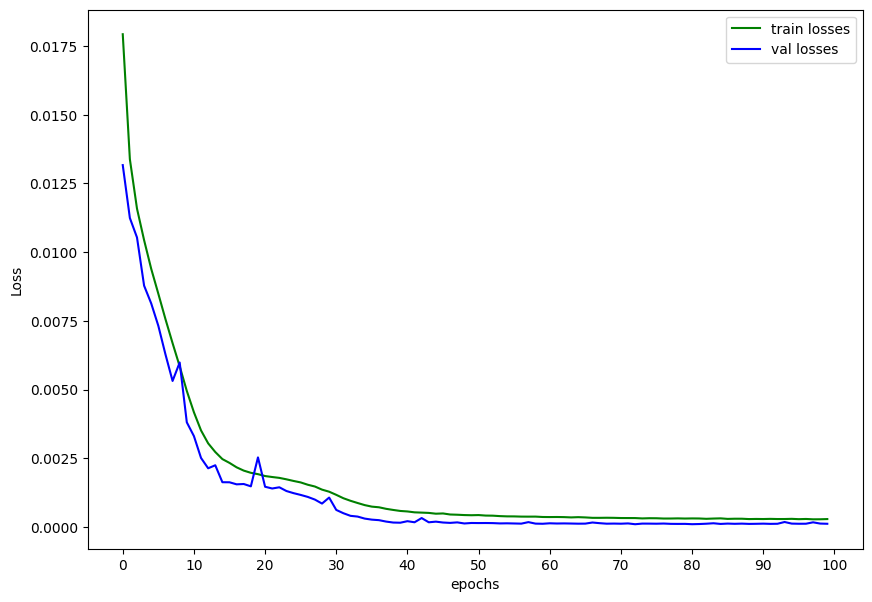

In [151]:
plt.figure(figsize=(10, 7))

plt.plot(train_loss, color='green', label='train losses')
plt.plot(val_loss, color='blue', label='val losses')
plt.xticks(range(0, epochs + 1, 10))
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
#plt.savefig('F:\Chrome downloads\loss_graph.png')
plt.show()

In [150]:
#torch.save(base_network.state_dict(), "./basenet.pt")
#torch.save(network.state_dict(), "./mainnet.pt")

In [51]:
load_base_net = BaseNetwork().to(device)
load_siamese_net = SiameseNetwork(load_base_net).to(device)

In [52]:
load_base_net.load_state_dict(torch.load("./basenet.pt", map_location=device))
load_siamese_net.load_state_dict(torch.load("./mainnet.pt", map_location=device))

<All keys matched successfully>

In [53]:
load_base_net.eval()

BaseNetwork(
  (cnn): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 30, kernel_size=(10, 10), stride=(1, 1))
    (2): Tanh()
    (3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): ReflectionPad2d((1, 1, 1, 1))
    (6): Conv2d(30, 20, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
    (8): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.1, inplace=False)
    (10): ReflectionPad2d((1, 1, 1, 1))
    (11): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1))
    (12): Tanh()
    (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout2d(p=0.1, inplace=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=30250, out_features=800, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=800, out_features=500, bias=True)
    (4): Tanh()
    (5)

In [54]:
load_siamese_net.eval()

SiameseNetwork(
  (base_network): BaseNetwork(
    (cnn): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(1, 30, kernel_size=(10, 10), stride=(1, 1))
      (2): Tanh()
      (3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout2d(p=0.1, inplace=False)
      (5): ReflectionPad2d((1, 1, 1, 1))
      (6): Conv2d(30, 20, kernel_size=(5, 5), stride=(1, 1))
      (7): Tanh()
      (8): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Dropout2d(p=0.1, inplace=False)
      (10): ReflectionPad2d((1, 1, 1, 1))
      (11): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1))
      (12): Tanh()
      (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (14): Dropout2d(p=0.1, inplace=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=30250, out_features=800, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.1, inplace=False)
      (3)

In [55]:
from torchsummary import summary
summary(load_base_net.to(device), input_size = (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1            [-1, 1, 66, 66]               0
            Conv2d-2           [-1, 30, 57, 57]           3,030
              Tanh-3           [-1, 30, 57, 57]               0
       BatchNorm2d-4           [-1, 30, 57, 57]              60
         Dropout2d-5           [-1, 30, 57, 57]               0
   ReflectionPad2d-6           [-1, 30, 59, 59]               0
            Conv2d-7           [-1, 20, 55, 55]          15,020
              Tanh-8           [-1, 20, 55, 55]               0
       BatchNorm2d-9           [-1, 20, 55, 55]              40
        Dropout2d-10           [-1, 20, 55, 55]               0
  ReflectionPad2d-11           [-1, 20, 57, 57]               0
           Conv2d-12           [-1, 10, 55, 55]           1,810
             Tanh-13           [-1, 10, 55, 55]               0
      BatchNorm2d-14           [-1, 10,

In [56]:
class_names = {0:'donut', 1:'scratch', 2:'random', 3:'edgeloc', 4:'edgering', 5:'center', 6:'nearfull', 7:'loc', 8:'none'}

complete_data = donut + scratch + random_ + edgeloc + edgering + center + nearfull + loc + none
random.shuffle(complete_data)

In [57]:
#converting raw images into 1D numpy array

dataset_images =[]
dataset_labels =[]
for (img, labl) in complete_data:
    dataset_images.append(img)
    dataset_labels.append(labl)
      
dataset_images = np.array(dataset_images)
dataset_labels = np.array(dataset_labels)
reshaped_img = dataset_images.reshape(dataset_images.shape[0], -1)
reshaped_labels = dataset_labels.reshape(dataset_images.shape[0], -1)    

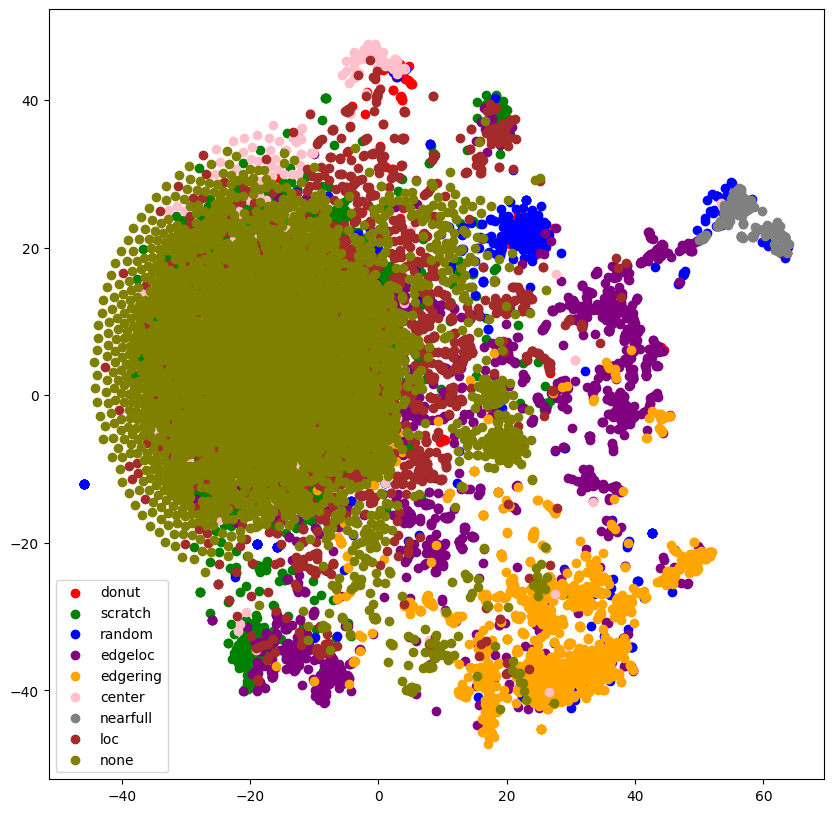

In [58]:
# Plotting 1D raw images in a 2D plot

tsne = TSNE(n_components=2, random_state=42)
imgs_2D = tsne.fit_transform(reshaped_img)

# Plot the results
plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    plt.scatter(imgs_2D[dataset_labels ==i, 0], imgs_2D[dataset_labels==i, 1], c=colors[i], label=str(class_names[i]))
plt.legend()
plt.show()

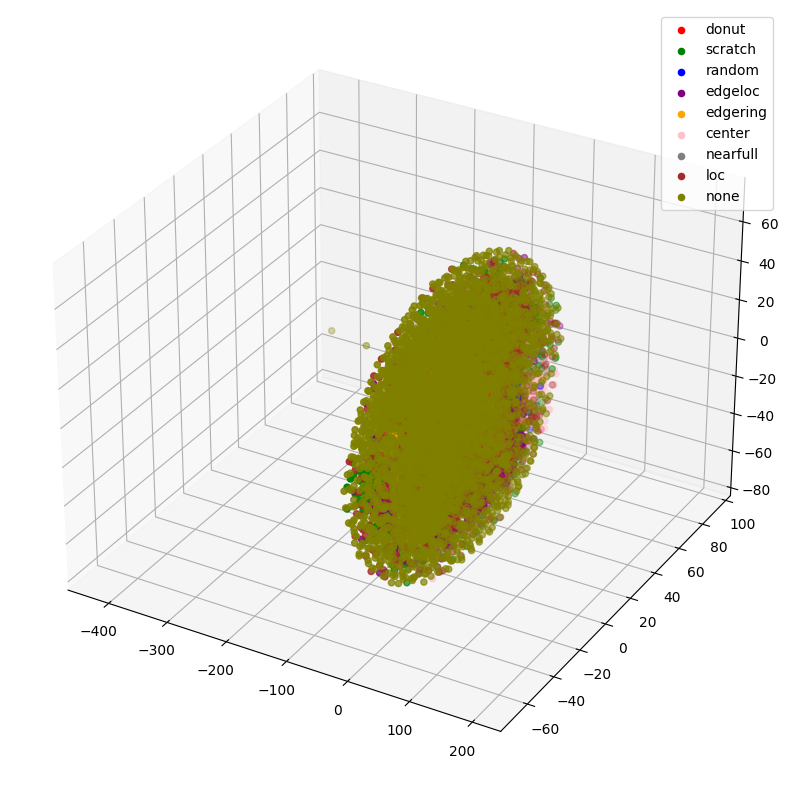

In [63]:
# Plotting 1D raw images in a 3D plot

tsne = TSNE(n_components=3, random_state=42)
imgs_2D = tsne.fit_transform(reshaped_img)

# Plot the results in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    ax.scatter(imgs_2D[dataset_labels==i, 0], imgs_2D[dataset_labels==i, 1], imgs_2D[dataset_labels==i, 2], c=colors[i], label=str(class_names[i]))
ax.legend()
plt.show()

In [60]:
#Generating feature embeddings using the subnetwork of a trained siamese.

embeddings = []
labels = []
with torch.no_grad():
    for (img, label) in complete_data:
       
        img = resize(img, (64,64))
        img = torch.from_numpy(img)
        img = img.float().to(device)
        img = img.view(1,1,64,64)
        label = torch.from_numpy(np.array([label], dtype=np.float32))
        output = load_base_net(img)
        embeddings.append(output)
        labels.append(label)
        
embeddings = torch.cat(embeddings, dim=0)
labels = torch.cat(labels, dim=0)

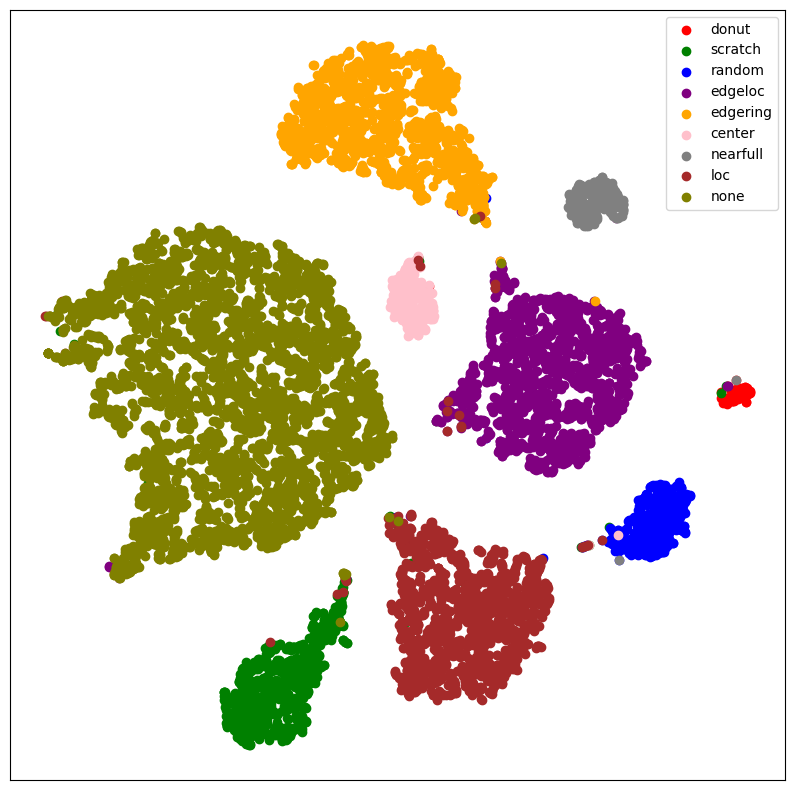

In [152]:
# Plotting the siamese generated embeddings in 2D.

tsne = TSNE(n_components=2, random_state=42)
embeddings_2D = tsne.fit_transform(embeddings.cpu())
labels = labels.cpu()

# Plot the results
plt.figure(figsize=(10, 10))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    plt.scatter(embeddings_2D[labels ==i, 0], embeddings_2D[labels==i, 1], c=colors[i], label=str(class_names[i]))
plt.legend()

# Remove x and y tick labels
plt.xticks([])
plt.yticks([])

plt.savefig('./gray_tsne_BCE_loss_2D_plot.png')

plt.show()

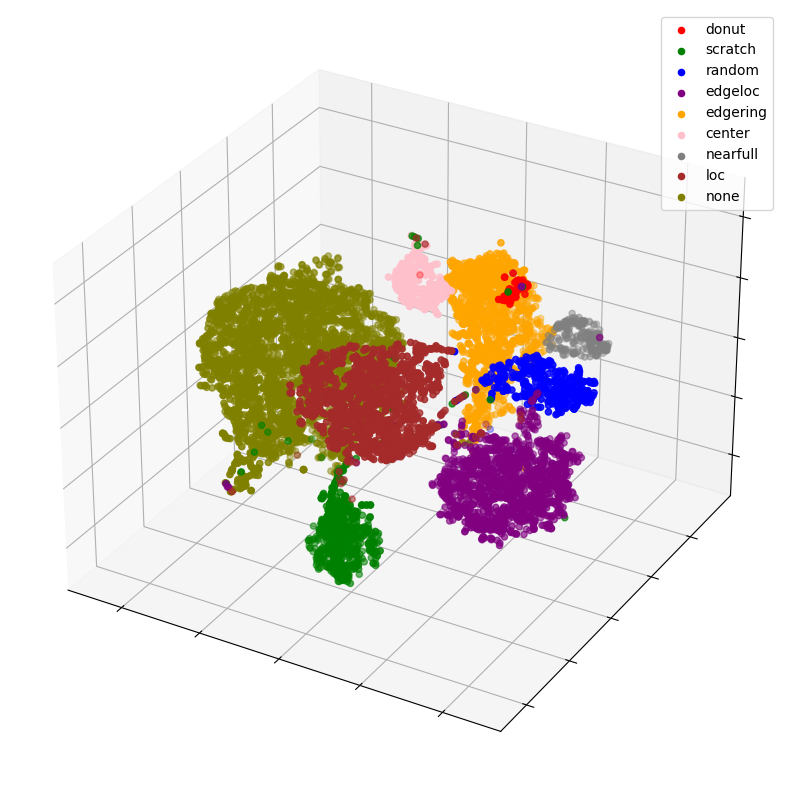

In [153]:
# Plotting the siamese generated embeddings in 3D

tsne = TSNE(n_components=3, random_state=42)
embeddings_2D = tsne.fit_transform(embeddings.cpu())
labels = labels.cpu()
# Plot the results in 3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'gray', 'brown', 'olive'] # list of colors for different classes
for i in range(len(colors)):
    ax.scatter(embeddings_2D[labels==i, 0], embeddings_2D[labels==i, 1], embeddings_2D[labels==i, 2], c=colors[i], label=str(class_names[i]))
ax.legend()


# Remove x, y, and z tick labels, but keep the grid
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Save the plot as an image file
plt.savefig('./tsne_BCE_loss_3D_plot.png')

plt.show()

In [64]:
#Creating list of different class data for easy access.
datasets = [donut, scratch, random_, edgeloc, edgering, center, nearfull, loc, none]

In [65]:
#Function to plot list of images
def plot_ref_imgs(ref_img_lst):
    fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(20, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(ref_img_lst[i])
        ax.axis("off")
        ax.set_title(class_names[i])

    # adjust the spacing between the subplots
    fig.subplots_adjust(wspace=0.2)

    # display the figure
    plt.show()

In [66]:
to_tensor = transforms.ToTensor()

## Generating normalized fingerprint vectors

In [67]:
embeddings = []
labels = []
with torch.no_grad():
    for (img, label) in tqdm(complete_data):
        img = resize(img, (64,64))
        img = torch.from_numpy(img)
        img = img.float().to(device)
        img = img.view(1,1,64,64)
        label = torch.from_numpy(np.array([label], dtype=np.float32))
        output = load_base_net(img)
        embeddings.append(output)
        labels.append(label)
        
embeddings = torch.cat(embeddings, dim=0).cpu()
labels = torch.cat(labels, dim=0).cpu()


100%|██████████| 10268/10268 [00:12<00:00, 855.06it/s]


In [69]:
class_wise_embeddings = {}
for i in range(9):
     class_wise_embeddings[i] = []
    
for i, (embedding, label) in enumerate(zip(embeddings, labels)):
    class_wise_embeddings[int(label)].append(embedding)

for key, value in class_wise_embeddings.items():
    count = len(value)
    print(f"Count of elements in {key}: {count}")


Count of elements in 0: 83
Count of elements in 1: 763
Count of elements in 2: 399
Count of elements in 3: 1582
Count of elements in 4: 1448
Count of elements in 5: 262
Count of elements in 6: 226
Count of elements in 7: 1411
Count of elements in 8: 4094


In [70]:
# Computing mean embeddings for each class

mean_class0 = torch.mean(torch.stack(class_wise_embeddings[0], dim =0), axis=0)
mean_class1 = torch.mean(torch.stack(class_wise_embeddings[1], dim =0), axis=0)
mean_class2 = torch.mean(torch.stack(class_wise_embeddings[2], dim =0), axis=0)
mean_class3 = torch.mean(torch.stack(class_wise_embeddings[3], dim =0), axis=0)
mean_class4 = torch.mean(torch.stack(class_wise_embeddings[4], dim =0), axis=0)
mean_class5 = torch.mean(torch.stack(class_wise_embeddings[5], dim =0), axis=0)
mean_class6 = torch.mean(torch.stack(class_wise_embeddings[6], dim =0), axis=0)
mean_class7 = torch.mean(torch.stack(class_wise_embeddings[7], dim =0), axis=0)
mean_class8 = torch.mean(torch.stack(class_wise_embeddings[8], dim =0), axis=0)

mean_of_embeddings =[mean_class0,mean_class1,mean_class2,mean_class3,mean_class4,mean_class5,mean_class6,mean_class7,mean_class8]


In [71]:
# Function to calculate euclidean distance similarity w.r.t centroid of each class.

def norm_dist_sim_vec_gen(ip_img, model, label, mean_of_classes, print_ = True):
    ip_img = resize(ip_img, (64,64))
    ip_img = to_tensor(ip_img).view(1,1,64,64).to(device).float()
    output_embedding = model(ip_img)
    
    out0_dist = F.pairwise_distance(output_embedding, mean_of_classes[0].cuda(), keepdim = True)
    out1_dist = F.pairwise_distance(output_embedding, mean_of_classes[1].cuda(), keepdim = True)
    out2_dist = F.pairwise_distance(output_embedding, mean_of_classes[2].cuda(), keepdim = True)
    out3_dist = F.pairwise_distance(output_embedding, mean_of_classes[3].cuda(), keepdim = True)
    out4_dist = F.pairwise_distance(output_embedding, mean_of_classes[4].cuda(), keepdim = True)
    out5_dist = F.pairwise_distance(output_embedding, mean_of_classes[5].cuda(), keepdim = True)
    out6_dist = F.pairwise_distance(output_embedding, mean_of_classes[6].cuda(), keepdim = True)
    out7_dist = F.pairwise_distance(output_embedding, mean_of_classes[7].cuda(), keepdim = True)
    out8_dist = F.pairwise_distance(output_embedding, mean_of_classes[8].cuda(), keepdim = True)
    
    concat_dist = torch.cat((out0_dist,out1_dist,out2_dist,out3_dist,out4_dist,out5_dist,out6_dist,out7_dist,out8_dist), dim=0)
  
    dist_vec = torch.tensor(concat_dist)
    min_idx_dist = torch.argmin(dist_vec).item()
    
    dist_sim_vec = dist_vec.detach().cpu().numpy().flatten()
  
    if print_ == True:
        print(f"The defect pattern belongs to \033[1mclass{min_idx_dist}\033[0m with the label \033[1m{class_names[min_idx_dist]}\033[0m ")
        print()
        print(f"Distance based feature vector:\033[1m{str(dist_sim_vec)}\033[0m ")
        print()

    return dist_sim_vec, min_idx_dist


## Inference

In [73]:
fingerprint_vec, label = norm_dist_sim_vec_gen(img, load_base_net, labels, mean_of_embeddings)

The defect pattern belongs to class7 with the label loc 

Distance based feature vector:[2.9585469  2.8356009  2.9917014  3.0441809  4.784438   3.30457
 4.419095   0.05520048 3.0857391 ] 



/tmp/ipykernel_2932614/741672716.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist_vec = torch.tensor(concat_dist)


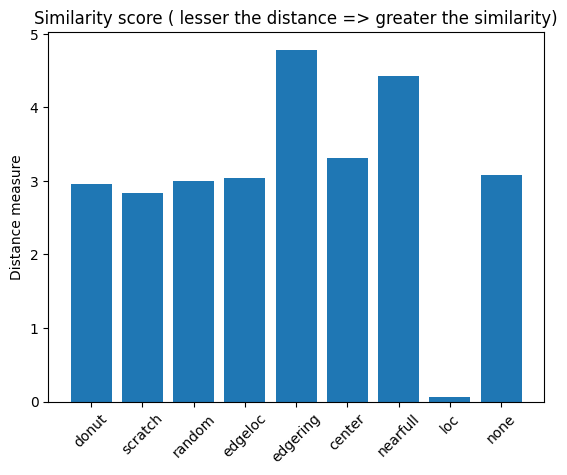

In [76]:
plt.bar(class_names.keys(), fingerprint_vec)
plt.xticks(list(class_names.keys()), class_names.values(), rotation=45)
plt.ylabel('Distance measure')
plt.title('Similarity score ( lesser the distance => greater the similarity)')
plt.show()

## Model Evaluation

In [78]:
test_data = donut_test + scratch_test + random_test + edgeloc_test + edgering_test + \
                  center_test + nearfull_test + loc_test + none_test
                                 
print(len(test_data))
random.shuffle(combined_data)

1032


  0%|          | 0/1032 [00:00<?, ?it/s]/tmp/ipykernel_2932614/741672716.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dist_vec = torch.tensor(concat_dist)
100%|██████████| 1032/1032 [00:02<00:00, 481.12it/s]


Overall Accuracy: 0.8992248062015504
Class-wise Precision, Recall, F1-score:
               precision    recall  f1-score   support

       donut       0.78      0.78      0.78         9
     scratch       0.80      0.52      0.63        77
      random       0.79      0.82      0.80        40
     edgeloc       0.89      0.91      0.90       159
    edgering       0.93      0.99      0.96       145
      center       0.77      0.85      0.81        27
    nearfull       0.96      0.96      0.96        23
         loc       0.81      0.81      0.81       142
        none       0.95      0.98      0.97       410

    accuracy                           0.90      1032
   macro avg       0.85      0.85      0.85      1032
weighted avg       0.90      0.90      0.90      1032



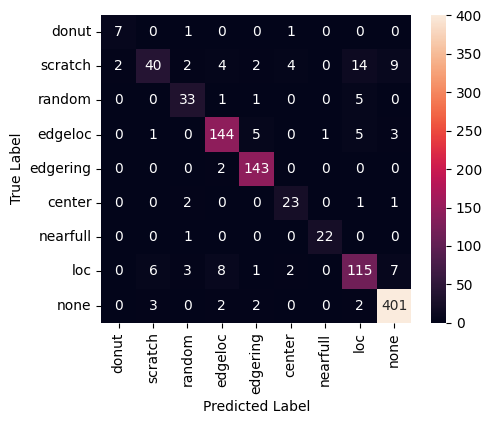

In [79]:
#Evaluation of the model using performance metricx

from sklearn.metrics import classification_report

def class_wise_report(test_dataset, data, model, label):
    y_true =[]
    y_pred =[]
    for i in tqdm(range(len(test_dataset))):
        image = test_dataset[i][0]
        image_label = test_dataset[i][1]
        _ , pred_label =  norm_dist_sim_vec_gen(image, load_base_net, labels, mean_of_embeddings, print_ = False)

        y_true.append(image_label)
        y_pred.append(pred_label)
    
    accuracy = accuracy_score(y_true, y_pred)
    print('Overall Accuracy:', accuracy)
    
    class_names_str = [class_names[i] for i in range(len(class_names))]

    class_report = classification_report(y_true, y_pred, target_names=class_names_str)
    print('Class-wise Precision, Recall, F1-score:\n', class_report)
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize = (5,4))
    sns.heatmap(cm, annot = True , fmt ='d', xticklabels=class_names_str, yticklabels=class_names_str)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.savefig('./Siamese_BCE_confusion_matrix.png')
    return accuracy, class_report, cm

accuracy, report, cm = class_wise_report(test_data, datasets, load_base_net, class_names)